In [1]:
import os
import sys
import time
import random
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso, BayesianRidge, ElasticNet

sys.path.append('../src')
import cb_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

In [2]:
# configuration
use_cache = True
seed = random.randint(0, 100)
print(f'Seed: {seed}')

Seed: 97


In [3]:
query = "SELECT * FROM junk.bjp_risk_strat_20200917;"
mems = cb_utils.sql_query_to_df(query, use_cache=use_cache)

Pulled query from cache


In [4]:
mems.head()

,mab_id,mco_id,member_id,segment,is_male,date_of_death,lob_end,grp_end,is_unaligned_end,is_pre,start_date,end_date,age,is_eol,lob,grp,lob_1_days,lob_2_days,lob_3_days,grp_1_days,grp_2_days,grp_3_days,unaligned_days,is_unaligned,pmpm,hcbs_pmpm,icf_pmpm,ip_pmpm,rx_pmpm,ed_pmpm,snf_pmpm,out_pmpm,pro_pmpm,spfac_pmpm,amb_pmpm,hh_pmpm,hosp_pmpm,oth_pmpm,tc,hcbs_tc,icf_tc,ip_tc,rx_tc,ed_tc,snf_tc,out_tc,pro_tc,spfac_tc,amb_tc,hh_tc,hosp_tc,oth_tc,p_mm,mm,tc_rec_6,hcbs_tc_rec_6,icf_tc_rec_6,ip_tc_rec_6,rx_tc_rec_6,ed_tc_rec_6,snf_tc_rec_6,out_tc_rec_6,pro_tc_rec_6,spfac_tc_rec_6,amb_tc_rec_6,hh_tc_rec_6,hosp_tc_rec_6,oth_tc_rec_6,p_mm_rec_6,mm_rec_6,pmpm_rec_6,hcbs_pmpm_rec_6,icf_pmpm_rec_6,ip_pmpm_rec_6,rx_pmpm_rec_6,ed_pmpm_rec_6,snf_pmpm_rec_6,out_pmpm_rec_6,pro_pmpm_rec_6,spfac_pmpm_rec_6,amb_pmpm_rec_6,hh_pmpm_rec_6,hosp_pmpm_rec_6,oth_pmpm_rec_6,hcbs_pcs_pmpm,hcbs_attd_pmpm,hcbs_respite_pmpm,hcbs_pcs_tc_rec_6,hcbs_attd_tc_rec_6,hcbs_respite_tc_rec_6,hcbs_pcs_tc,hcbs_attd_tc,hcbs_respite_tc,hcbs_fam_care_stip_tc,hcbs_com_trans_tc,hcbs_educ_train_tc,hcbs_com_liv_fam_tc,hcbs_com_liv_tc,hcbs_com_trans_waiv_tc,hcbs_home_meal_tc,hcbs_ther_behav_tc,hcbs_unsk_respite_tc,hcbs_waiv_svc_tc,ddos,hcbs_ddos,amb_ddos,ed_ddos,ip_ddos,snf_ddos,icf_ddos,hh_ddos,out_ddos,rx_ddos,pro_ddos,spfac_ddos,hosp_ddos,oth_ddos,ddos_rec_6,hcbs_ddos_rec_6,amb_ddos_rec_6,ed_ddos_rec_6,ip_ddos_rec_6,snf_ddos_rec_6,icf_ddos_rec_6,hh_ddos_rec_6,out_ddos_rec_6,rx_ddos_rec_6,pro_ddos_rec_6,spfac_ddos_rec_6,hosp_ddos_rec_6,oth_ddos_rec_6,pcp_ddos_rec_6,fall_ddos_rec_6,pcp_ddos,chf_ddos,heart_ddos,copd_ddos,pulmonar_ddos,cancer_ddos,ckd_ddos,esrd_ddos,hyperlipid_ddos,diab_ddos,alzh_ddos,dementia_ddos,stroke_ddos,hypertension_ddos,fall_ddos,transplant_ddos,liver_ddos,hippfract_ddos,depression_ddos,psychosis_ddos,drug_ddos,alcohol_ddos,tbi_ddos,obese_ddos,paralysis_ddos,paral_mono_ddos,paral_mono_dom_ddos,paral_hemi_ddos,paral_hemi_dom_ddos,paral_para_ddos,paral_quad_ddos
0,12,2,1,,0,None,3,2,False,1,2019-09-07,2020-09-01,68,False,3,2,0.0,0.0,360.0,0.0,360.0,0.0,0.0,False,5395.13,2778.97,NaN,952.47,1361.32,0.0,NaN,55.23,194.65,NaN,NaN,52.50,NaN,None,64741.60,33347.64,NaN,11429.58,16335.84,0.0,NaN,662.73,2335.81,NaN,NaN,630.0,NaN,None,12.0,12,20915.77,14454.64,NaN,NaN,5811.99,NaN,NaN,409.11,240.03,NaN,NaN,NaN,NaN,None,6.0,6,3485.961667,2409.106667,NaN,NaN,968.665000,NaN,NaN,68.185000,40.005000,NaN,NaN,NaN,NaN,None,1491.93,417.71,None,6477.36,5012.48,None,17903.16,5012.48,None,None,None,None,NaN,NaN,NaN,NaN,None,973.10,None,336.0,330.0,NaN,NaN,1.0,NaN,NaN,7.0,7.0,29.0,16.0,None,NaN,None,156.0,153.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,15.0,4.0,None,NaN,None,4.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,8.0,15.0,141.0,22.0,14.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12,2,16,,1,None,3,2,False,1,2019-09-07,2020-09-01,24,False,3,2,0.0,0.0,360.0,0.0,360.0,0.0,0.0,False,3012.52,1471.38,NaN,429.70,705.04,NaN,NaN,NaN,406.40,NaN,NaN,NaN,NaN,None,36150.21,17656.56,NaN,5156.45,8460.43,NaN,NaN,NaN,4876.77,NaN,NaN,NaN,NaN,None,12.0,12,10906.78,8362.48,NaN,NaN,798.17,NaN,NaN,NaN,1746.13,NaN,NaN,NaN,NaN,None,6.0,6,1817.796667,1393.746667,NaN,NaN,133.028333,NaN,NaN,NaN,291.021667,NaN,NaN,NaN,NaN,None,NaN,1471.38,None,NaN,8362.48,None,NaN,17656.56,None,None,None,None,NaN,NaN,NaN,NaN,None,NaN,None,210.0,187.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,28.0,32.0,None,NaN,None,95.0,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,10.0,None,NaN,None,2.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12,2,19,,1,None,3,3,False,1,2019-09-07,2020-09-01,74,False,3,3,0.0,0.0,360.0,0.0,0.0,360.0,0.0,False,2316.82,1044.10,NaN,NaN,308.98,NaN,NaN,22.21,250.19,NaN,NaN,691.35,NaN,None,27801.88,12529.15,NaN,NaN,3707.71,NaN,NaN,266.51,3002.31,NaN,NaN,8296.2,NaN,None,12.0,12,13929.09,6419.17,NaN,NaN,1770.36,NaN,NaN,134.45,1629.06,NaN,NaN,3976.05,NaN,None,6.0,6,2321.515000,1069.861667,NaN,NaN,295.060000,NaN,NaN,22.408333,271.510000

In [5]:
mems.shape

(560, 164)

In [6]:
mems.describe()

,mab_id,mco_id,member_id,is_male,lob_end,grp_end,is_pre,age,lob,grp,lob_1_days,lob_2_days,lob_3_days,grp_1_days,grp_2_days,grp_3_days,unaligned_days,pmpm,hcbs_pmpm,icf_pmpm,ip_pmpm,rx_pmpm,ed_pmpm,snf_pmpm,out_pmpm,pro_pmpm,spfac_pmpm,amb_pmpm,hh_pmpm,hosp_pmpm,tc,hcbs_tc,icf_tc,ip_tc,rx_tc,ed_tc,snf_tc,out_tc,pro_tc,spfac_tc,amb_tc,hh_tc,hosp_tc,p_mm,mm,tc_rec_6,hcbs_tc_rec_6,icf_tc_rec_6,ip_tc_rec_6,rx_tc_rec_6,ed_tc_rec_6,snf_tc_rec_6,out_tc_rec_6,pro_tc_rec_6,spfac_tc_rec_6,amb_tc_rec_6,hh_tc_rec_6,hosp_tc_rec_6,p_mm_rec_6,mm_rec_6,pmpm_rec_6,hcbs_pmpm_rec_6,icf_pmpm_rec_6,ip_pmpm_rec_6,rx_pmpm_rec_6,ed_pmpm_rec_6,snf_pmpm_rec_6,out_pmpm_rec_6,pro_pmpm_rec_6,spfac_pmpm_rec_6,amb_pmpm_rec_6,hh_pmpm_rec_6,hosp_pmpm_rec_6,hcbs_pcs_pmpm,hcbs_attd_pmpm,hcbs_pcs_tc_rec_6,hcbs_attd_tc_rec_6,hcbs_pcs_tc,hcbs_attd_tc,hcbs_com_liv_fam_tc,hcbs_com_liv_tc,hcbs_com_trans_waiv_tc,hcbs_home_meal_tc,hcbs_unsk_respite_tc,ddos,hcbs_ddos,amb_ddos,ed_ddos,ip_ddos,snf_ddos,icf_ddos,hh_ddos,out_ddos,rx_ddos,pro_ddos,hosp_ddos,ddos_rec_6,hcbs_ddos_rec_6,amb_ddos_rec_6,ed_ddos_rec_6,ip_ddos_rec_6,snf_ddos_rec_6,icf_ddos_rec_6,hh_ddos_rec_6,out_ddos_rec_6,rx_ddos_rec_6,pro_ddos_rec_6,hosp_ddos_rec_6,pcp_ddos_rec_6,fall_ddos_rec_6,pcp_ddos,chf_ddos,heart_ddos,copd_ddos,pulmonar_ddos,cancer_ddos,ckd_ddos,esrd_ddos,hyperlipid_ddos,diab_ddos,alzh_ddos,dementia_ddos,stroke_ddos,hypertension_ddos,fall_ddos,transplant_ddos,liver_ddos,hippfract_ddos,depression_ddos,psychosis_ddos,drug_ddos,alcohol_ddos,tbi_ddos,obese_ddos,paralysis_ddos,paral_mono_ddos,paral_mono_dom_ddos,paral_hemi_ddos,paral_hemi_dom_ddos,paral_para_ddos,paral_quad_ddos
count,560.0,560.0,560.000000,560.000000,560.000000,560.000000,560.0,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,25.000000,216.000000,554.000000,311.000000,59.000000,376.000000,558.000000,3.0,325.000000,314.000000,1.00,560.000000,560.000000,25.000000,216.000000,554.000000,311.000000,59.000000,376.000000,558.000000,3.0,325.000000,314.000000,1.00,560.0,560.0,560.000000,559.000000,11.000000,105.000000,544.000000,187.000000,27.000000,266.000000,553.000000,3.0,205.000000,231.000000,1.00,560.0,560.0,560.000000,559.000000,11.000000,105.000000,544.000000,187.000000,27.000000,266.000000,553.000000,3.0,205.000000,231.000000,1.000000,327.000000,408.000000,297.000000,399.000000,327.000000,408.000000,3.000000,1.0,1.0,117.000000,373.000000,560.000000,560.000000,323.000000,306.000000,208.000000,58.000000,23.000000,312.000000,359.000000,553.000000,556.000000,1.0,560.000000,559.000000,202.000000,182.000000,101.000000,27.000000,11.000000,228.000000,262.000000,544.000000,535.000000,1.0,468.000000,58.000000,533.000000,208.000000,297.000000,242.000000,30.000000,50.000000,234.000000,24.000000,337.000000,294.000000,46.000000,135.000000,180.000000,454.000000,98.000000,2.000000,54.000000,15.000000,204.000000,63.000000,25.000000,17.000000,5.000000,137.000000,228.000000,42.000000,1.0,44.000000,123.000000,75.000000,63.000000
mean,12.0,2.0,3422.280357,0.305357,2.700000,2.089286,1.0,65.576786,2.700000,2.103571,55.435714,0.021429,304.542857,0.030357,322.241071,37.230357,1.285714,5913.163696,2537.399607,593.587600,1607.280324,1486.642888,186.364855,653.757119,268.843750,523.169032,0.0,170.578092,506.347229,841.01,70957.958839,30448.789821,7123.042800,19287.359722,17839.707852,2236.372347,7845.079661,3226.116888,6278.024409,0.0,2046.932831,6076.166624,10092.17,12.0,12.0,33030.343786,15007.630948,7148.178182,17319.729619,8277.630846,1566.672406,7487.684444,1841.548947,2882.138517,0.0,1419.203902,3582.923203,10092.17,6.0,6.0,5505.057298,2501.271825,1191.363030,2886.621603,1379.605141,261.112068,1247.947407,306.924825,480.356420,0.0,236.533984,597.153867,1682.028333,1298.142905,2226.284191,8212.642727,13811.828872,15577.699052,26715.405735,23517.366667,34584.0,500.0,1090.265983,1518.001769,290.580357,270.385714,4.857585,3.248366,2.086538,4.620690,2.260870,45.974359,9.949

In [7]:
pmpm_cols = [c for c in mems.columns if c[-5:] == '_pmpm']

In [8]:
pmpm_cuts = mems[pmpm_cols].describe(percentiles=[.5, .75, .8, .85, .9, .95])
pmpm_cuts

,hcbs_pmpm,icf_pmpm,ip_pmpm,rx_pmpm,ed_pmpm,snf_pmpm,out_pmpm,pro_pmpm,spfac_pmpm,amb_pmpm,hh_pmpm,hosp_pmpm,hcbs_pcs_pmpm,hcbs_attd_pmpm
count,560.000000,25.000000,216.000000,554.000000,311.000000,59.000000,376.000000,558.000000,3.0,325.000000,314.000000,1.00,327.000000,408.000000
mean,2537.399607,593.587600,1607.280324,1486.642888,186.364855,653.757119,268.843750,523.169032,0.0,170.578092,506.347229,841.01,1298.142905,2226.284191
std,1153.840865,527.454867,2011.271055,2767.628664,245.124599,381.809380,1046.588559,714.025961,0.0,474.766994,669.544264,NaN,1011.279783,1225.591086
min,94.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,841.01,5.130000,54.630000
50%,2441.765000,360.090000,949.770000,718.940000,103.780000,608.000000,39.675000,310.435000,0.0,68.570000,363.550000,841.01,1050.950000,2123.410000
75%,3274.117500,821.740000,1888.605000,1519.782500,213.900000,867.330000,147.262500,627.622500,0.0,159.050000,701.150000,841.01,1956.785000,2922.315000
80%,3521.012000,1109.986000,2205.840000,1895.456000,278.890000,969.770000,207.000000,756.250000,0.0,189.224000,808.794000,841.01,2082.038000,3130.242000
85%,3793.730000,1160.238000,2689.450000,2279.331500,332.970000,1042.117000,321.077500,907.406000,0.0,262.044000,899.832000,841.01,2352.254000,3556.220500
90%,4138.701000,1303.236000,3714.055000,3164.488000,430.310000,1086.752000,584.670000,1219.275000,0.0,327.256000,1032.662000,841.01,2837.080000,3994.697000
95%,4562.126500,1516.244000,4751.665000,5416.013500,621.285000,1359.220000,1193.357500,1671.856500,0.0,506.462000,1290.942500,841.01,3322.559000,4368.557000


In [9]:
pmpm_cuts.loc["90%"].sort_values(ascending=False)

hcbs_pmpm         4138.701
hcbs_attd_pmpm    3994.697
ip_pmpm           3714.055
rx_pmpm           3164.488
hcbs_pcs_pmpm     2837.080
icf_pmpm          1303.236
pro_pmpm          1219.275
snf_pmpm          1086.752
hh_pmpm           1032.662
hosp_pmpm          841.010
out_pmpm           584.670
ed_pmpm            430.310
amb_pmpm           327.256
spfac_pmpm           0.000
Name: 90%, dtype: float64

## Check out members who are in the top ten in multiple PMPM categories

In [10]:
top_ten_cols = []
for c in pmpm_cuts.columns:
    tt_col = f'{c}_top_10_pct'
    top_ten_cols.append(tt_col)
    mems = mems.assign(**{tt_col: np.where(mems[c] >= pmpm_cuts.loc['90%'][c], 1, 0)})

In [11]:
top_ten_cols

['hcbs_pmpm_top_10_pct',
 'icf_pmpm_top_10_pct',
 'ip_pmpm_top_10_pct',
 'rx_pmpm_top_10_pct',
 'ed_pmpm_top_10_pct',
 'snf_pmpm_top_10_pct',
 'out_pmpm_top_10_pct',
 'pro_pmpm_top_10_pct',
 'spfac_pmpm_top_10_pct',
 'amb_pmpm_top_10_pct',
 'hh_pmpm_top_10_pct',
 'hosp_pmpm_top_10_pct',
 'hcbs_pcs_pmpm_top_10_pct',
 'hcbs_attd_pmpm_top_10_pct']

In [12]:
mems = mems.assign(total_top_ten=mems[top_ten_cols].sum(axis=1))

In [13]:
mems.total_top_ten.describe(percentiles=[.90 + (step / 100.0) for step in range(1, 10)])

count    560.000000
mean       0.735714
std        1.055597
min        0.000000
50%        0.000000
91%        2.000000
92%        2.000000
93%        2.000000
94%        3.000000
95%        3.000000
96%        3.000000
97%        3.000000
98%        4.000000
99%        4.000000
max        6.000000
Name: total_top_ten, dtype: float64

In [14]:
mems.total_top_ten.value_counts()

0    319
1    127
2     77
3     24
4      8
5      3
6      2
Name: total_top_ten, dtype: int64

In [15]:
ddos_cols = [c for c in mems.columns if c[-5:] == '_ddos']
ddos_cols 

['hcbs_ddos',
 'amb_ddos',
 'ed_ddos',
 'ip_ddos',
 'snf_ddos',
 'icf_ddos',
 'hh_ddos',
 'out_ddos',
 'rx_ddos',
 'pro_ddos',
 'spfac_ddos',
 'hosp_ddos',
 'oth_ddos',
 'pcp_ddos',
 'chf_ddos',
 'heart_ddos',
 'copd_ddos',
 'pulmonar_ddos',
 'cancer_ddos',
 'ckd_ddos',
 'esrd_ddos',
 'hyperlipid_ddos',
 'diab_ddos',
 'alzh_ddos',
 'dementia_ddos',
 'stroke_ddos',
 'hypertension_ddos',
 'fall_ddos',
 'transplant_ddos',
 'liver_ddos',
 'hippfract_ddos',
 'depression_ddos',
 'psychosis_ddos',
 'drug_ddos',
 'alcohol_ddos',
 'tbi_ddos',
 'obese_ddos',
 'paralysis_ddos',
 'paral_mono_ddos',
 'paral_mono_dom_ddos',
 'paral_hemi_ddos',
 'paral_hemi_dom_ddos',
 'paral_para_ddos',
 'paral_quad_ddos']

In [16]:
spend_ddos = ['hcbs_ddos', 'amb_ddos', 'ed_ddos', 'ip_ddos', 'snf_ddos', 'icf_ddos', 'hh_ddos', 'out_ddos', 'rx_ddos', 'pro_ddos', 'spfac_ddos', 'hosp_ddos', 'oth_ddos',]
dx_ddos = ['chf_ddos', 'heart_ddos', 'copd_ddos', 'pulmonar_ddos', 'cancer_ddos', 'ckd_ddos', 'esrd_ddos', 'hyperlipid_ddos', 'diab_ddos', 'alzh_ddos', 'dementia_ddos', 'stroke_ddos', 'hypertension_ddos', 'fall_ddos', 'transplant_ddos', 'liver_ddos', 'hippfract_ddos', 'depression_ddos', 'psychosis_ddos', 'drug_ddos', 'alcohol_ddos', 'tbi_ddos', 'obese_ddos', 'paralysis_ddos', 'paral_mono_ddos', 'paral_mono_dom_ddos', 'paral_hemi_ddos', 'paral_hemi_dom_ddos', 'paral_para_ddos', 'paral_quad_ddos']

## Break out into some focus groups

### HCBS

In [17]:
hcbs_risk = mems.loc[mems.hcbs_pmpm_top_10_pct > 0]
hcbs_risk.sort_values('hcbs_pmpm_top_10_pct', ascending=False).head()

,mab_id,mco_id,member_id,segment,is_male,date_of_death,lob_end,grp_end,is_unaligned_end,is_pre,start_date,end_date,age,is_eol,lob,grp,lob_1_days,lob_2_days,lob_3_days,grp_1_days,grp_2_days,grp_3_days,unaligned_days,is_unaligned,pmpm,hcbs_pmpm,icf_pmpm,ip_pmpm,rx_pmpm,ed_pmpm,snf_pmpm,out_pmpm,pro_pmpm,spfac_pmpm,amb_pmpm,hh_pmpm,hosp_pmpm,oth_pmpm,tc,hcbs_tc,icf_tc,ip_tc,rx_tc,ed_tc,snf_tc,out_tc,pro_tc,spfac_tc,amb_tc,hh_tc,hosp_tc,oth_tc,p_mm,mm,tc_rec_6,hcbs_tc_rec_6,icf_tc_rec_6,ip_tc_rec_6,rx_tc_rec_6,ed_tc_rec_6,snf_tc_rec_6,out_tc_rec_6,pro_tc_rec_6,spfac_tc_rec_6,amb_tc_rec_6,hh_tc_rec_6,hosp_tc_rec_6,oth_tc_rec_6,p_mm_rec_6,mm_rec_6,pmpm_rec_6,hcbs_pmpm_rec_6,icf_pmpm_rec_6,ip_pmpm_rec_6,rx_pmpm_rec_6,ed_pmpm_rec_6,snf_pmpm_rec_6,out_pmpm_rec_6,pro_pmpm_rec_6,spfac_pmpm_rec_6,amb_pmpm_rec_6,hh_pmpm_rec_6,hosp_pmpm_rec_6,oth_pmpm_rec_6,hcbs_pcs_pmpm,hcbs_attd_pmpm,hcbs_respite_pmpm,hcbs_pcs_tc_rec_6,hcbs_attd_tc_rec_6,hcbs_respite_tc_rec_6,hcbs_pcs_tc,hcbs_attd_tc,hcbs_respite_tc,hcbs_fam_care_stip_tc,hcbs_com_trans_tc,hcbs_educ_train_tc,hcbs_com_liv_fam_tc,hcbs_com_liv_tc,hcbs_com_trans_waiv_tc,hcbs_home_meal_tc,hcbs_ther_behav_tc,hcbs_unsk_respite_tc,hcbs_waiv_svc_tc,ddos,hcbs_ddos,amb_ddos,ed_ddos,ip_ddos,snf_ddos,icf_ddos,hh_ddos,out_ddos,rx_ddos,pro_ddos,spfac_ddos,hosp_ddos,oth_ddos,ddos_rec_6,hcbs_ddos_rec_6,amb_ddos_rec_6,ed_ddos_rec_6,ip_ddos_rec_6,snf_ddos_rec_6,icf_ddos_rec_6,hh_ddos_rec_6,out_ddos_rec_6,rx_ddos_rec_6,pro_ddos_rec_6,spfac_ddos_rec_6,hosp_ddos_rec_6,oth_ddos_rec_6,pcp_ddos_rec_6,fall_ddos_rec_6,pcp_ddos,chf_ddos,heart_ddos,copd_ddos,pulmonar_ddos,cancer_ddos,ckd_ddos,esrd_ddos,hyperlipid_ddos,diab_ddos,alzh_ddos,dementia_ddos,stroke_ddos,hypertension_ddos,fall_ddos,transplant_ddos,liver_ddos,hippfract_ddos,depression_ddos,psychosis_ddos,drug_ddos,alcohol_ddos,tbi_ddos,obese_ddos,paralysis_ddos,paral_mono_ddos,paral_mono_dom_ddos,paral_hemi_ddos,paral_hemi_dom_ddos,paral_para_ddos,paral_quad_ddos,hcbs_pmpm_top_10_pct,icf_pmpm_top_10_pct,ip_pmpm_top_10_pct,rx_pmpm_top_10_pct,ed_pmpm_top_10_pct,snf_pmpm_top_10_pct,out_pmpm_top_10_pct,pro_pmpm_top_10_pct,spfac_pmpm_top_10_pct,amb_pmpm_top_10_pct,hh_pmpm_top_10_pct,hosp_pmpm_top_10_pct,hcbs_pcs_pmpm_top_10_pct,hcbs_attd_pmpm_top_10_pct,total_top_ten
16,12,2,107,,0,None,3,2,False,1,2019-09-07,2020-09-01,91,False,3,2,0.0,0.0,360.0,0.0,360.0,0.0,0.0,False,7094.73,5329.86,NaN,NaN,545.54,229.02,NaN,165.00,288.64,NaN,NaN,536.67,NaN,None,85136.72,63958.34,NaN,NaN,6546.52,2748.26,NaN,1979.95,3463.65,NaN,NaN,6440.00,NaN,None,12.0,12,42099.54,33924.83,NaN,NaN,2580.75,446.56,NaN,826.83,1460.57,NaN,NaN,2860.00,NaN,None,6.0,6,7016.590000,5654.138333,NaN,NaN,430.125000,74.426667,NaN,137.805000,243.428333,NaN,NaN,476.666667,NaN,None,NaN,5328.17,None,NaN,33924.83,None,NaN,63937.99,None,None,None,None,NaN,NaN,NaN,NaN,None,20.35,None,340.0,335.0,NaN,3.0,NaN,NaN,NaN,45.0,16.0,77.0,34.0,None,NaN,None,168.0,167.0,NaN,1.0,NaN,NaN,NaN,20.0,7.0,38.0,12.0,None,NaN,None,1.0,NaN,5.0,NaN,NaN,39.0,NaN,NaN,44.0,NaN,1.0,NaN,NaN,NaN,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2
28,12,2,190,,0,None,3,2,False,1,2019-09-07,2020-09-01,101,False,3,2,0.0,0.0,360.0,0.0,360.0,0.0,0.0,False,6125.75,5053.99,NaN,NaN,101.24,121.89,NaN,4.87,174.36,NaN,41.94,627.47,NaN,None,73509.02,60647.83,NaN,NaN,1214.91,1462.64,NaN,58.42,2092.26,NaN,503.32,7529.64,NaN,None,12.0,12,37059.79,29839.63,NaN,NaN,638.79,1350.59,NaN,58.42,1267.68,NaN,503.32,3401.36,NaN,None,6.0,6,6176.631667,4973.271667,NaN,NaN,106.465000,225.098333,NaN,9.736667,211.280000,NaN,83.886667,566.893333,NaN,None,NaN,5047.88,None,NaN,29770.44,None,NaN,60574.57,None,None,None,None,NaN,NaN,NaN,NaN,None,73.26,None,339.0,335.0,1.0,5.0,NaN,NaN,NaN,87.0,1.0,21.0,39.0,None,NaN,None,159.0,155.0,1.0,4.0,NaN,NaN,NaN,41.0,1.0,12.0,20.0,None,NaN,None,3.0,44.0,9.0,48.0,47.0,11.0,NaN,2.0,46.0,NaN,1.0,48.0,NaN,12.0,NaN,5.0,44.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1

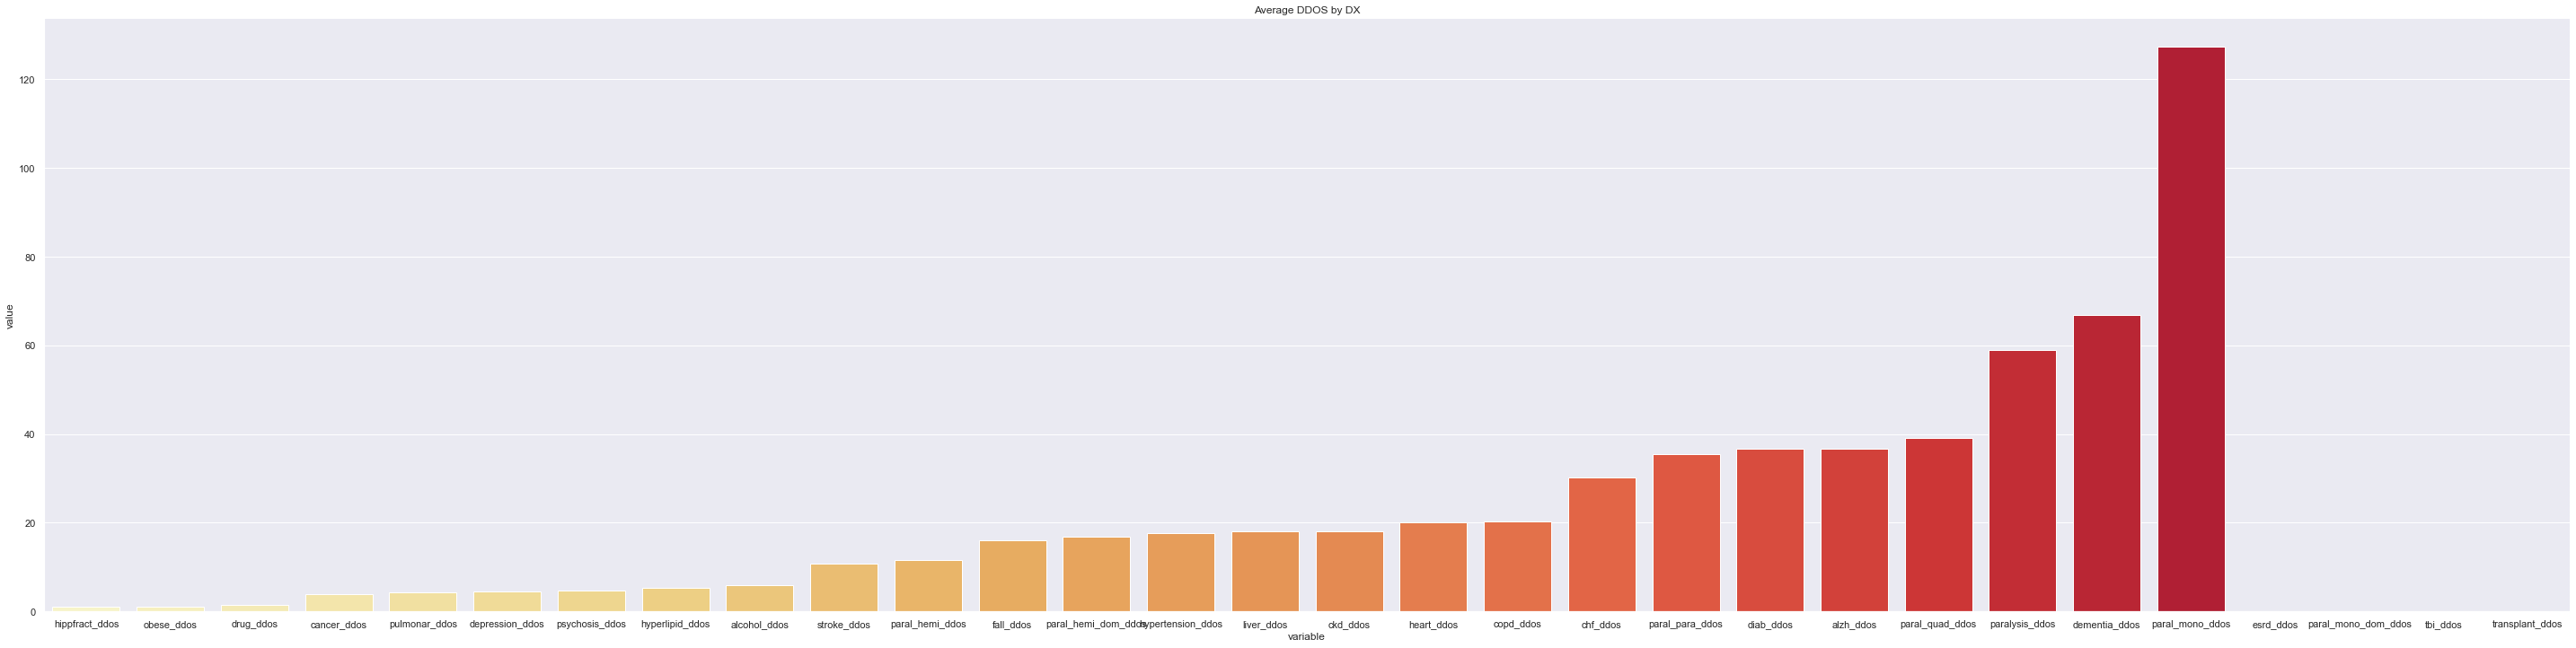

In [24]:
hcbs_dx_melt = hcbs_risk[dx_ddos + ['pmpm', 'hcbs_pmpm']].melt(id_vars=['pmpm', 'hcbs_pmpm'])
hcbs_dx_melt_grped = hcbs_dx_melt.groupby('variable', as_index=False).agg('mean').sort_values('value')
g = sns.catplot(x='variable', y='value', palette='YlOrRd', kind='bar', data=hcbs_dx_melt_grped, height=10, aspect=4)
g.set(title="Average DDOS by DX")

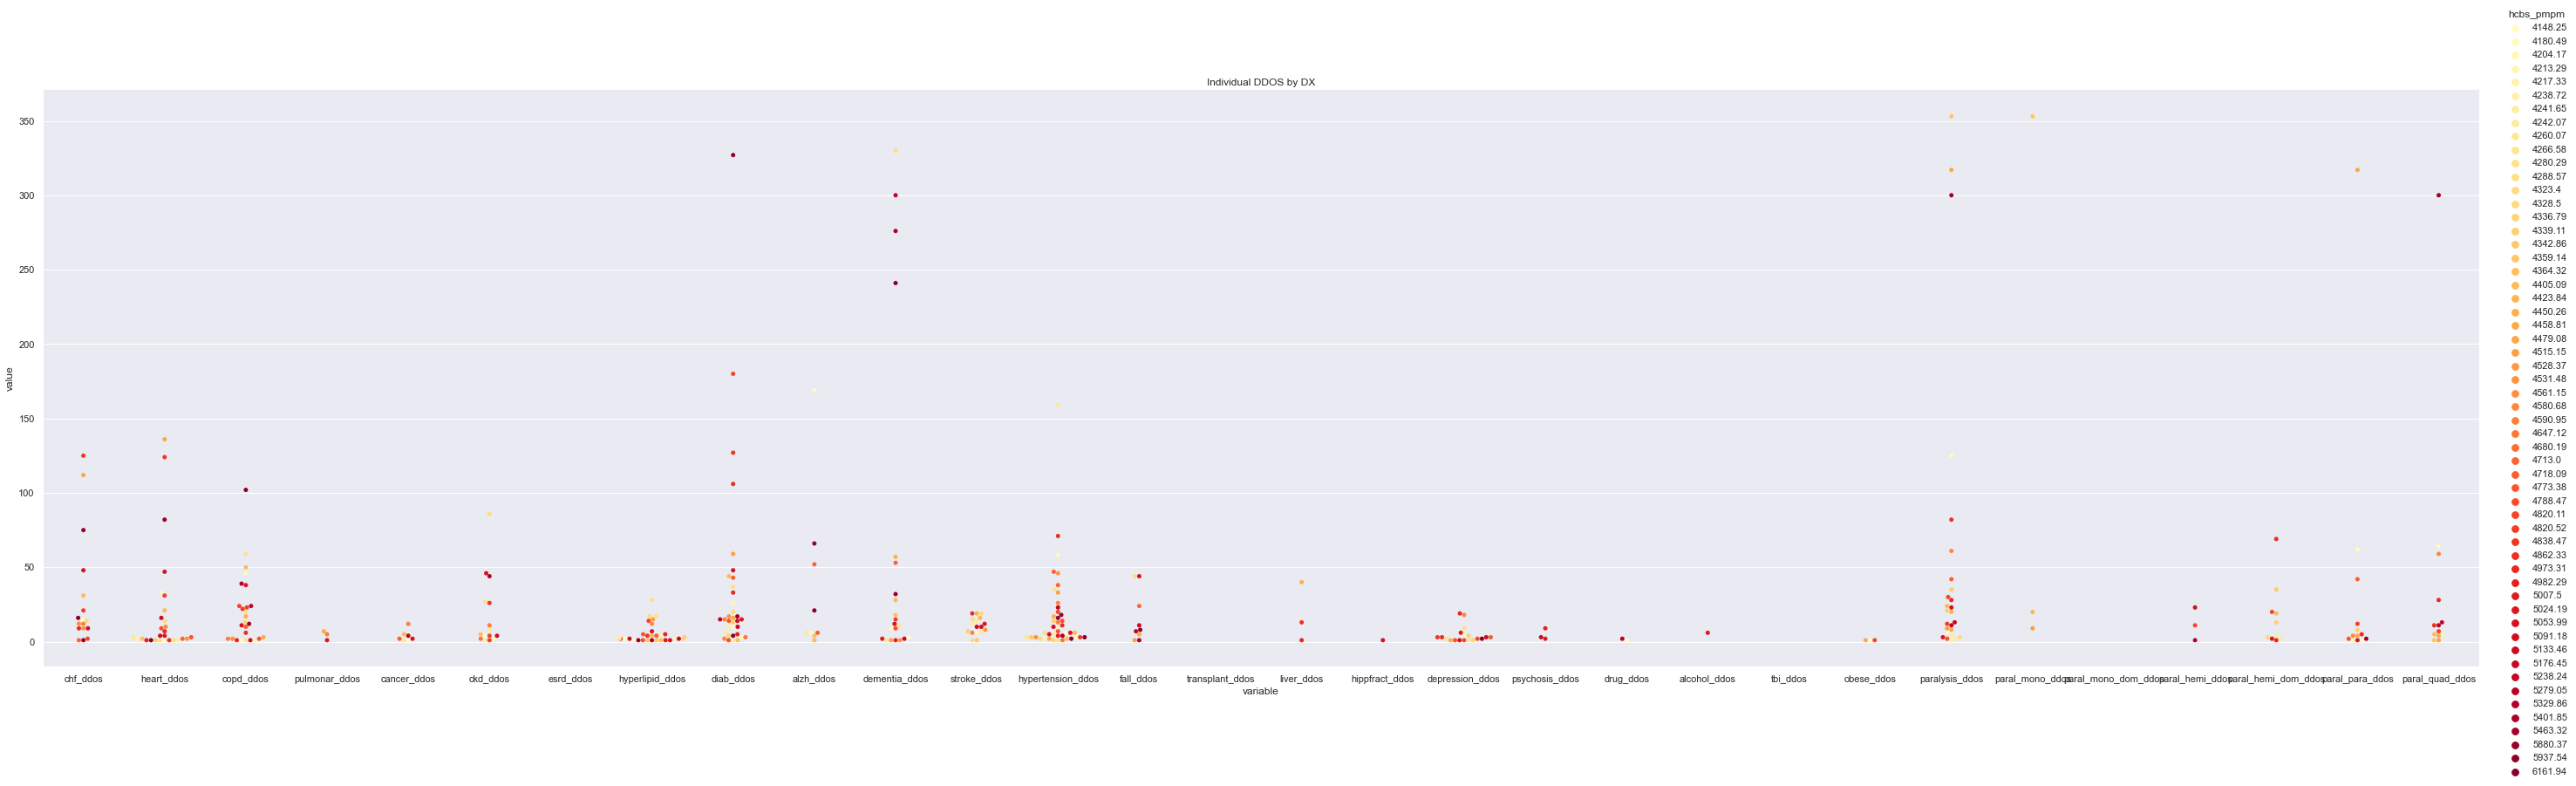

In [26]:
hcbs_dx_melt = hcbs_risk[dx_ddos + ['pmpm', 'hcbs_pmpm']].melt(id_vars=['pmpm', 'hcbs_pmpm'])
g = sns.catplot(x='variable', y='value', hue='hcbs_pmpm', kind='swarm', palette='YlOrRd', data=hcbs_dx_melt, height=10, aspect=4)
g.set(title='Individual DDOS by DX')

### IP

In [27]:
ip_risk = mems.loc[mems.ip_pmpm_top_10_pct > 0]
ip_risk.sort_values('ip_pmpm_top_10_pct', ascending=False).head()

,mab_id,mco_id,member_id,segment,is_male,date_of_death,lob_end,grp_end,is_unaligned_end,is_pre,start_date,end_date,age,is_eol,lob,grp,lob_1_days,lob_2_days,lob_3_days,grp_1_days,grp_2_days,grp_3_days,unaligned_days,is_unaligned,pmpm,hcbs_pmpm,icf_pmpm,ip_pmpm,rx_pmpm,ed_pmpm,snf_pmpm,out_pmpm,pro_pmpm,spfac_pmpm,amb_pmpm,hh_pmpm,hosp_pmpm,oth_pmpm,tc,hcbs_tc,icf_tc,ip_tc,rx_tc,ed_tc,snf_tc,out_tc,pro_tc,spfac_tc,amb_tc,hh_tc,hosp_tc,oth_tc,p_mm,mm,tc_rec_6,hcbs_tc_rec_6,icf_tc_rec_6,ip_tc_rec_6,rx_tc_rec_6,ed_tc_rec_6,snf_tc_rec_6,out_tc_rec_6,pro_tc_rec_6,spfac_tc_rec_6,amb_tc_rec_6,hh_tc_rec_6,hosp_tc_rec_6,oth_tc_rec_6,p_mm_rec_6,mm_rec_6,pmpm_rec_6,hcbs_pmpm_rec_6,icf_pmpm_rec_6,ip_pmpm_rec_6,rx_pmpm_rec_6,ed_pmpm_rec_6,snf_pmpm_rec_6,out_pmpm_rec_6,pro_pmpm_rec_6,spfac_pmpm_rec_6,amb_pmpm_rec_6,hh_pmpm_rec_6,hosp_pmpm_rec_6,oth_pmpm_rec_6,hcbs_pcs_pmpm,hcbs_attd_pmpm,hcbs_respite_pmpm,hcbs_pcs_tc_rec_6,hcbs_attd_tc_rec_6,hcbs_respite_tc_rec_6,hcbs_pcs_tc,hcbs_attd_tc,hcbs_respite_tc,hcbs_fam_care_stip_tc,hcbs_com_trans_tc,hcbs_educ_train_tc,hcbs_com_liv_fam_tc,hcbs_com_liv_tc,hcbs_com_trans_waiv_tc,hcbs_home_meal_tc,hcbs_ther_behav_tc,hcbs_unsk_respite_tc,hcbs_waiv_svc_tc,ddos,hcbs_ddos,amb_ddos,ed_ddos,ip_ddos,snf_ddos,icf_ddos,hh_ddos,out_ddos,rx_ddos,pro_ddos,spfac_ddos,hosp_ddos,oth_ddos,ddos_rec_6,hcbs_ddos_rec_6,amb_ddos_rec_6,ed_ddos_rec_6,ip_ddos_rec_6,snf_ddos_rec_6,icf_ddos_rec_6,hh_ddos_rec_6,out_ddos_rec_6,rx_ddos_rec_6,pro_ddos_rec_6,spfac_ddos_rec_6,hosp_ddos_rec_6,oth_ddos_rec_6,pcp_ddos_rec_6,fall_ddos_rec_6,pcp_ddos,chf_ddos,heart_ddos,copd_ddos,pulmonar_ddos,cancer_ddos,ckd_ddos,esrd_ddos,hyperlipid_ddos,diab_ddos,alzh_ddos,dementia_ddos,stroke_ddos,hypertension_ddos,fall_ddos,transplant_ddos,liver_ddos,hippfract_ddos,depression_ddos,psychosis_ddos,drug_ddos,alcohol_ddos,tbi_ddos,obese_ddos,paralysis_ddos,paral_mono_ddos,paral_mono_dom_ddos,paral_hemi_ddos,paral_hemi_dom_ddos,paral_para_ddos,paral_quad_ddos,hcbs_pmpm_top_10_pct,icf_pmpm_top_10_pct,ip_pmpm_top_10_pct,rx_pmpm_top_10_pct,ed_pmpm_top_10_pct,snf_pmpm_top_10_pct,out_pmpm_top_10_pct,pro_pmpm_top_10_pct,spfac_pmpm_top_10_pct,amb_pmpm_top_10_pct,hh_pmpm_top_10_pct,hosp_pmpm_top_10_pct,hcbs_pcs_pmpm_top_10_pct,hcbs_attd_pmpm_top_10_pct,total_top_ten
15,12,2,106,,0,None,3,2,False,1,2019-09-07,2020-09-01,74,False,3,2,0.0,0.0,360.0,0.0,360.0,0.0,0.0,False,10584.33,1930.65,NaN,4157.96,1021.13,114.05,902.5,83.75,1294.75,NaN,275.27,804.27,NaN,None,127011.94,23167.80,NaN,49895.50,12253.57,1368.54,10830.0,1005.05,15536.96,NaN,3303.27,9651.25,NaN,None,12.0,12,67452.14,11869.76,NaN,32135.12,3448.67,1368.54,NaN,991.02,10429.75,NaN,2219.28,4990.0,NaN,None,6.0,6,11242.023333,1978.293333,NaN,5355.853333,574.778333,228.090,NaN,165.170000,1738.291667,NaN,369.880000,831.666667,NaN,None,NaN,1871.08,None,NaN,11470.32,None,NaN,22452.92,None,None,None,None,NaN,NaN,NaN,714.88,None,NaN,None,295.0,253.0,9.0,2.0,7.0,3.0,NaN,76.0,12.0,58.0,91.0,None,NaN,None,159.0,136.0,5.0,2.0,5.0,NaN,NaN,44.0,11.0,31.0,61.0,None,NaN,None,6.0,NaN,14.0,132.0,111.0,228.0,NaN,NaN,92.0,NaN,5.0,102.0,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,1,0,0,0,0,0,0,2
36,12,2,248,,1,None,3,2,False,1,2019-09-07,2020-09-01,67,False,3,2,0.0,0.0,360.0,0.0,360.0,0.0,0.0,False,15948.30,2626.14,NaN,7987.12,2065.67,79.27,NaN,837.32,1666.97,NaN,268.33,417.48,NaN,None,191379.59,31513.65,NaN,95845.42,24788.05,951.27,NaN,10047.85,20003.65,NaN,3219.90,5009.80,NaN,None,12.0,12,105136.37,18061.35,NaN,58753.92,11447.88,951.27,NaN,32.60,11554.16,NaN,2204.19,2131.0,NaN,None,6.0,6,17522.728333,3010.225000,NaN,9792.320000,1907.980000,158.545,NaN,5.433333,1925.693333,NaN,367.365000,355.166667,NaN,None,1959.86,NaN,None,14197.05,NaN,None,23518.26,NaN,None,None,None,None,NaN,NaN,NaN,1088.60,None,6906.79,None,316.0,257.0,8.0,1.0,7.0,NaN,NaN,42.0,5.0,50.0,80.0,None,NaN,None,169.0,142.0,6.0,1.0,4.0,NaN,NaN,19.0,2.0,26.0,43.0,None,NaN,None,10.0,NaN,18.0,4.0,13.0,81.0,NaN,NaN,

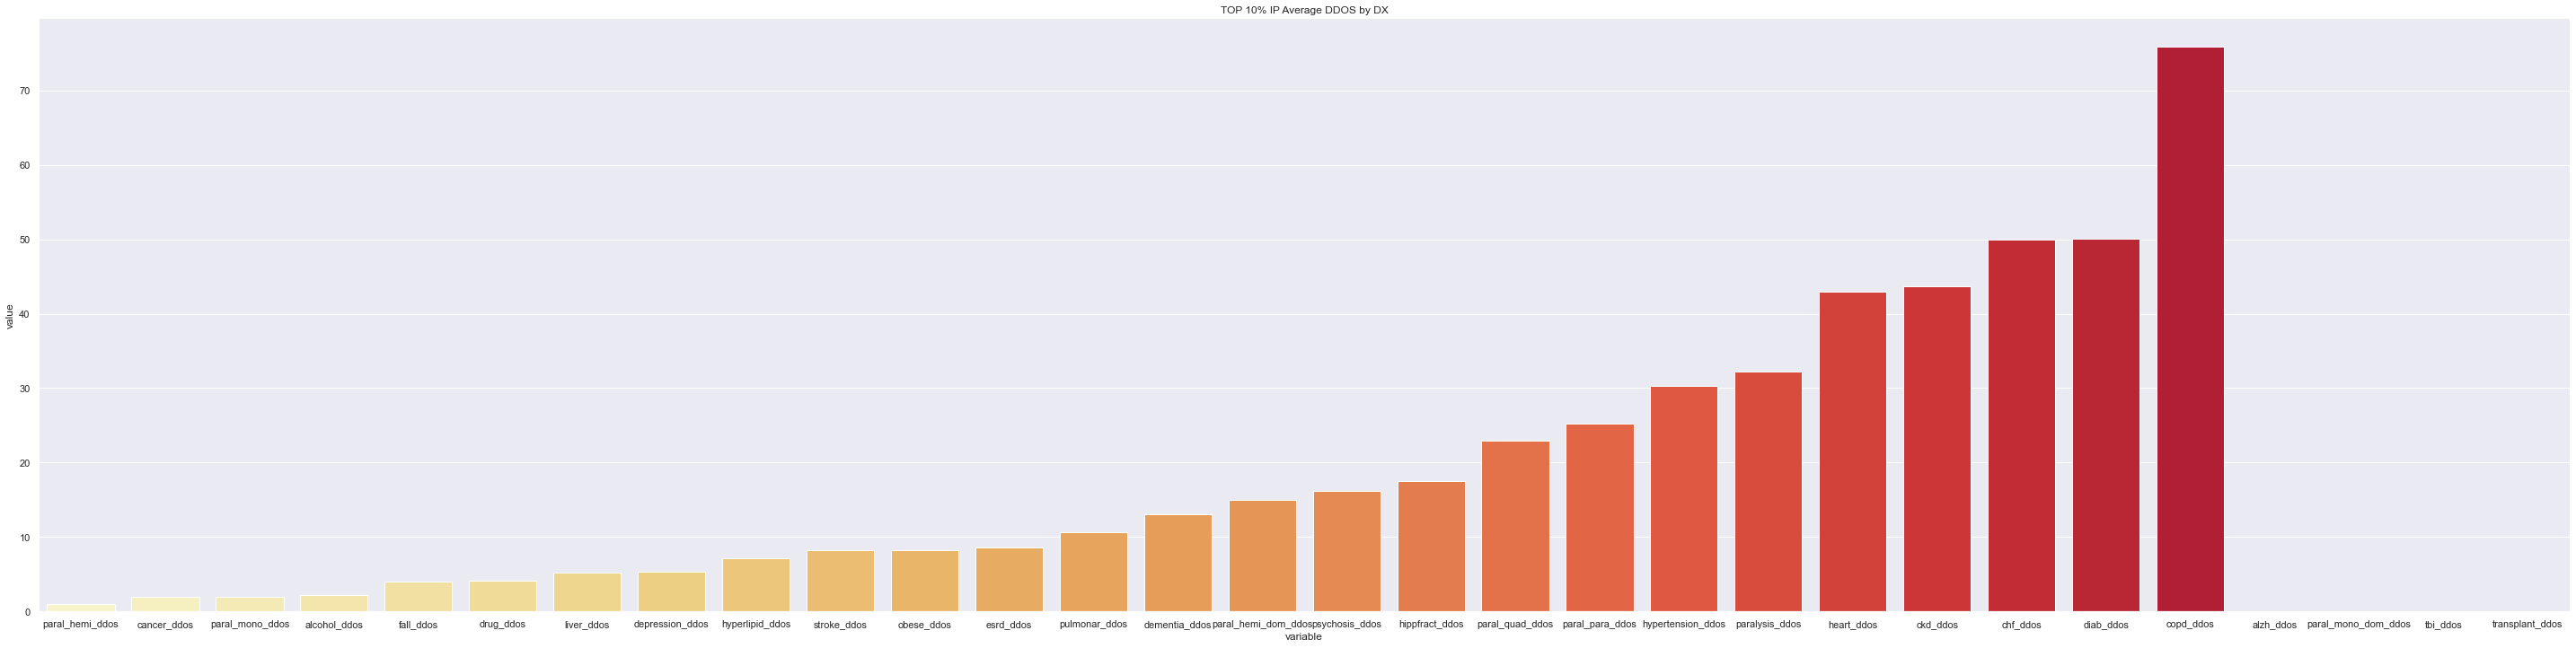

In [29]:
ip_dx_melt = ip_risk[dx_ddos + ['pmpm', 'ip_pmpm']].melt(id_vars=['pmpm', 'ip_pmpm'])
ip_dx_melt_grped = ip_dx_melt.groupby('variable', as_index=False).agg('mean').sort_values('value')
g = sns.catplot(x='variable', y='value', palette='YlOrRd', kind='bar', data=ip_dx_melt_grped, height=10, aspect=4)
g.set(title="TOP 10% IP Average DDOS by DX")

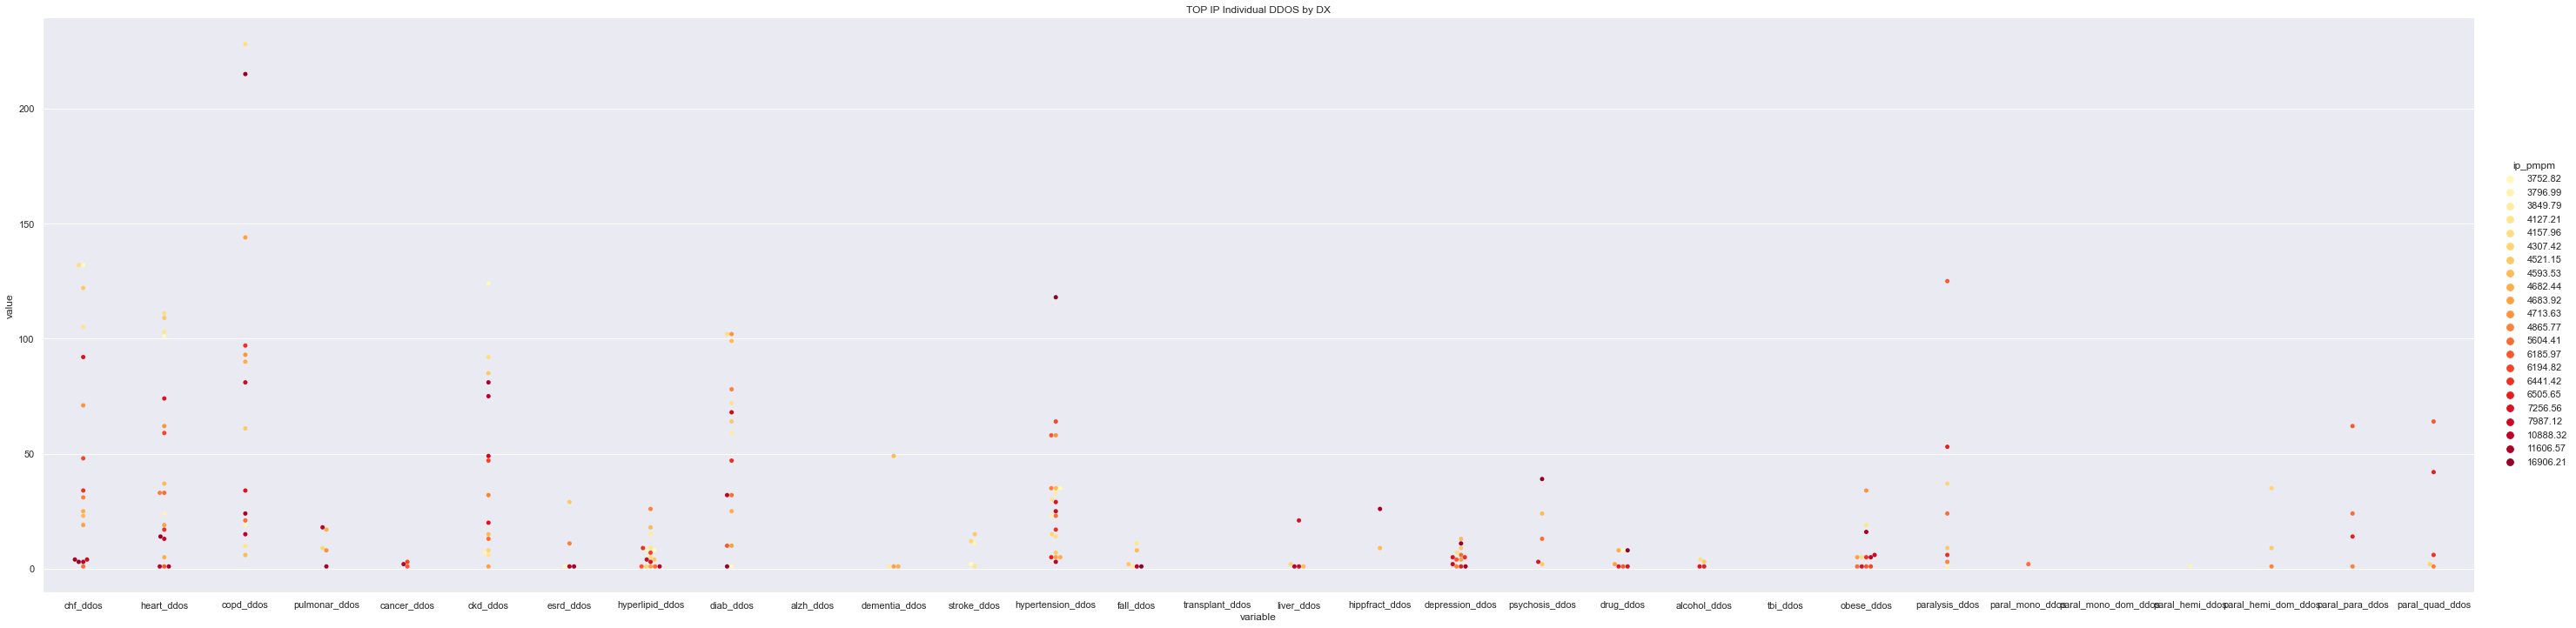

In [30]:
ip_melt = ip_risk[dx_ddos + ['pmpm', 'ip_pmpm']].melt(id_vars=['pmpm', 'ip_pmpm'])
g = sns.catplot(x='variable', y='value', hue='ip_pmpm', kind='swarm', palette='YlOrRd', data=ip_melt, height=10, aspect=4)
g.set(title='TOP IP Individual DDOS by DX')

### RX

In [31]:
rx_risk = mems.loc[mems.rx_pmpm_top_10_pct > 0]
rx_risk.sort_values('rx_pmpm_top_10_pct', ascending=False).head()

,mab_id,mco_id,member_id,segment,is_male,date_of_death,lob_end,grp_end,is_unaligned_end,is_pre,start_date,end_date,age,is_eol,lob,grp,lob_1_days,lob_2_days,lob_3_days,grp_1_days,grp_2_days,grp_3_days,unaligned_days,is_unaligned,pmpm,hcbs_pmpm,icf_pmpm,ip_pmpm,rx_pmpm,ed_pmpm,snf_pmpm,out_pmpm,pro_pmpm,spfac_pmpm,amb_pmpm,hh_pmpm,hosp_pmpm,oth_pmpm,tc,hcbs_tc,icf_tc,ip_tc,rx_tc,ed_tc,snf_tc,out_tc,pro_tc,spfac_tc,amb_tc,hh_tc,hosp_tc,oth_tc,p_mm,mm,tc_rec_6,hcbs_tc_rec_6,icf_tc_rec_6,ip_tc_rec_6,rx_tc_rec_6,ed_tc_rec_6,snf_tc_rec_6,out_tc_rec_6,pro_tc_rec_6,spfac_tc_rec_6,amb_tc_rec_6,hh_tc_rec_6,hosp_tc_rec_6,oth_tc_rec_6,p_mm_rec_6,mm_rec_6,pmpm_rec_6,hcbs_pmpm_rec_6,icf_pmpm_rec_6,ip_pmpm_rec_6,rx_pmpm_rec_6,ed_pmpm_rec_6,snf_pmpm_rec_6,out_pmpm_rec_6,pro_pmpm_rec_6,spfac_pmpm_rec_6,amb_pmpm_rec_6,hh_pmpm_rec_6,hosp_pmpm_rec_6,oth_pmpm_rec_6,hcbs_pcs_pmpm,hcbs_attd_pmpm,hcbs_respite_pmpm,hcbs_pcs_tc_rec_6,hcbs_attd_tc_rec_6,hcbs_respite_tc_rec_6,hcbs_pcs_tc,hcbs_attd_tc,hcbs_respite_tc,hcbs_fam_care_stip_tc,hcbs_com_trans_tc,hcbs_educ_train_tc,hcbs_com_liv_fam_tc,hcbs_com_liv_tc,hcbs_com_trans_waiv_tc,hcbs_home_meal_tc,hcbs_ther_behav_tc,hcbs_unsk_respite_tc,hcbs_waiv_svc_tc,ddos,hcbs_ddos,amb_ddos,ed_ddos,ip_ddos,snf_ddos,icf_ddos,hh_ddos,out_ddos,rx_ddos,pro_ddos,spfac_ddos,hosp_ddos,oth_ddos,ddos_rec_6,hcbs_ddos_rec_6,amb_ddos_rec_6,ed_ddos_rec_6,ip_ddos_rec_6,snf_ddos_rec_6,icf_ddos_rec_6,hh_ddos_rec_6,out_ddos_rec_6,rx_ddos_rec_6,pro_ddos_rec_6,spfac_ddos_rec_6,hosp_ddos_rec_6,oth_ddos_rec_6,pcp_ddos_rec_6,fall_ddos_rec_6,pcp_ddos,chf_ddos,heart_ddos,copd_ddos,pulmonar_ddos,cancer_ddos,ckd_ddos,esrd_ddos,hyperlipid_ddos,diab_ddos,alzh_ddos,dementia_ddos,stroke_ddos,hypertension_ddos,fall_ddos,transplant_ddos,liver_ddos,hippfract_ddos,depression_ddos,psychosis_ddos,drug_ddos,alcohol_ddos,tbi_ddos,obese_ddos,paralysis_ddos,paral_mono_ddos,paral_mono_dom_ddos,paral_hemi_ddos,paral_hemi_dom_ddos,paral_para_ddos,paral_quad_ddos,hcbs_pmpm_top_10_pct,icf_pmpm_top_10_pct,ip_pmpm_top_10_pct,rx_pmpm_top_10_pct,ed_pmpm_top_10_pct,snf_pmpm_top_10_pct,out_pmpm_top_10_pct,pro_pmpm_top_10_pct,spfac_pmpm_top_10_pct,amb_pmpm_top_10_pct,hh_pmpm_top_10_pct,hosp_pmpm_top_10_pct,hcbs_pcs_pmpm_top_10_pct,hcbs_attd_pmpm_top_10_pct,total_top_ten
6,12,2,31,,1,None,3,2,False,1,2019-09-07,2020-09-01,80,False,3,2,0.0,0.0,360.0,0.0,360.0,0.0,0.0,False,9912.00,2101.02,NaN,NaN,5542.25,105.47,NaN,24.92,505.66,NaN,28.08,1604.60,NaN,None,118944.01,25212.24,NaN,NaN,66507.01,1265.61,NaN,299.02,6067.93,NaN,336.95,19255.25,NaN,None,12.0,12,69995.84,12823.32,NaN,NaN,41505.72,31.99,NaN,170.16,2411.65,NaN,NaN,13053.0,NaN,None,6.0,6,11665.973333,2137.220000,NaN,NaN,6917.620000,5.331667,NaN,28.360000,401.941667,NaN,NaN,2175.5,NaN,None,1859.78,NaN,None,11557.32,NaN,None,22317.30,NaN,None,None,None,None,NaN,NaN,NaN,1764.0,None,1130.94,None,349.0,349.0,1.0,4.0,NaN,NaN,NaN,113.0,4.0,70.0,59.0,None,NaN,None,169.0,169.0,NaN,1.0,NaN,NaN,NaN,70.0,2.0,32.0,25.0,None,NaN,None,9.0,NaN,20.0,98.0,124.0,60.0,NaN,NaN,92.0,NaN,2.0,105.0,27.0,27.0,NaN,7.0,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN,25.0,NaN,NaN,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2
12,12,2,85,,0,None,3,2,False,1,2019-09-07,2020-09-01,40,False,3,2,0.0,0.0,360.0,0.0,360.0,0.0,0.0,False,9353.91,2029.11,NaN,NaN,4011.29,NaN,NaN,2882.51,431.00,NaN,NaN,NaN,NaN,None,112246.95,24349.32,NaN,NaN,48135.52,NaN,NaN,34590.10,5172.01,NaN,NaN,NaN,NaN,None,12.0,12,58117.59,11726.40,NaN,NaN,41635.16,NaN,NaN,2727.91,2028.12,NaN,NaN,NaN,NaN,None,6.0,6,9686.265000,1954.400000,NaN,NaN,6939.193333,NaN,NaN,454.651667,338.020000,NaN,NaN,NaN,NaN,None,2029.11,NaN,None,11726.40,NaN,None,24349.32,NaN,None,None,None,None,NaN,NaN,NaN,NaN,None,NaN,None,351.0,350.0,NaN,NaN,NaN,NaN,NaN,NaN,16.0,41.0,41.0,None,NaN,None,171.0,170.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,24.0,20.0,None,NaN,None,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,2.0,8.0,3.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2


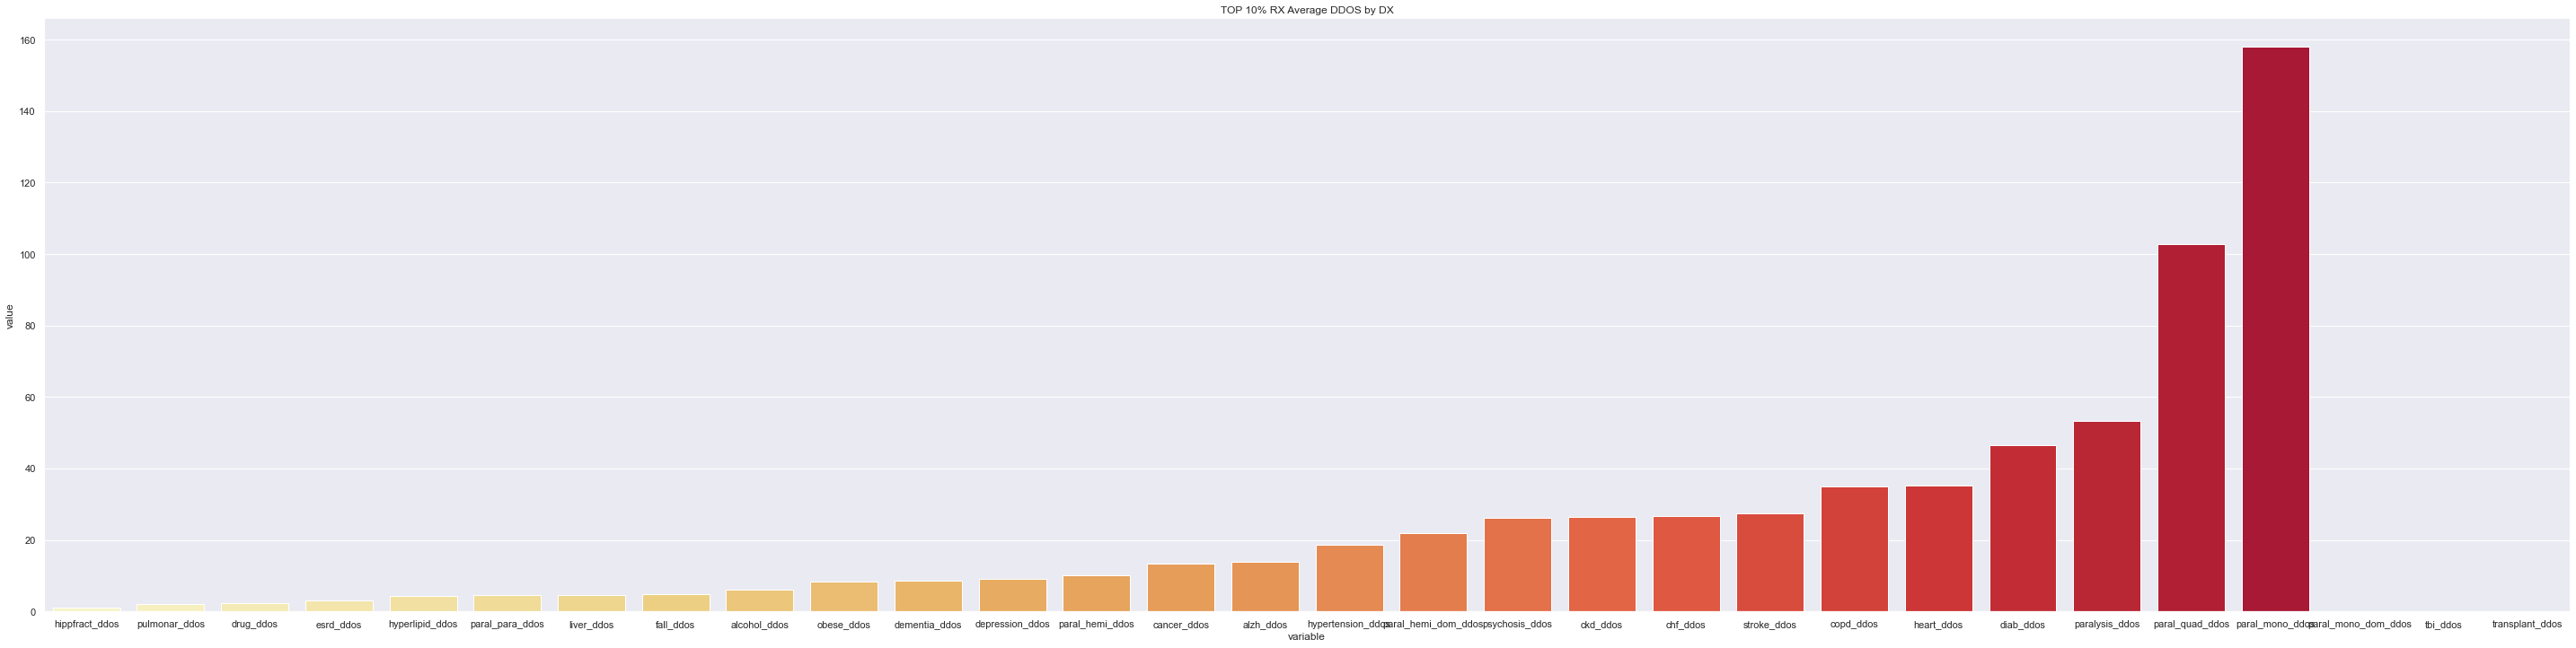

In [32]:
rx_dx_melt = rx_risk[dx_ddos + ['pmpm', 'rx_pmpm']].melt(id_vars=['pmpm', 'rx_pmpm'])
rx_dx_melt_grped = rx_dx_melt.groupby('variable', as_index=False).agg('mean').sort_values('value')
g = sns.catplot(x='variable', y='value', palette='YlOrRd', kind='bar', data=rx_dx_melt_grped, height=10, aspect=4)
g.set(title="TOP 10% RX Average DDOS by DX")

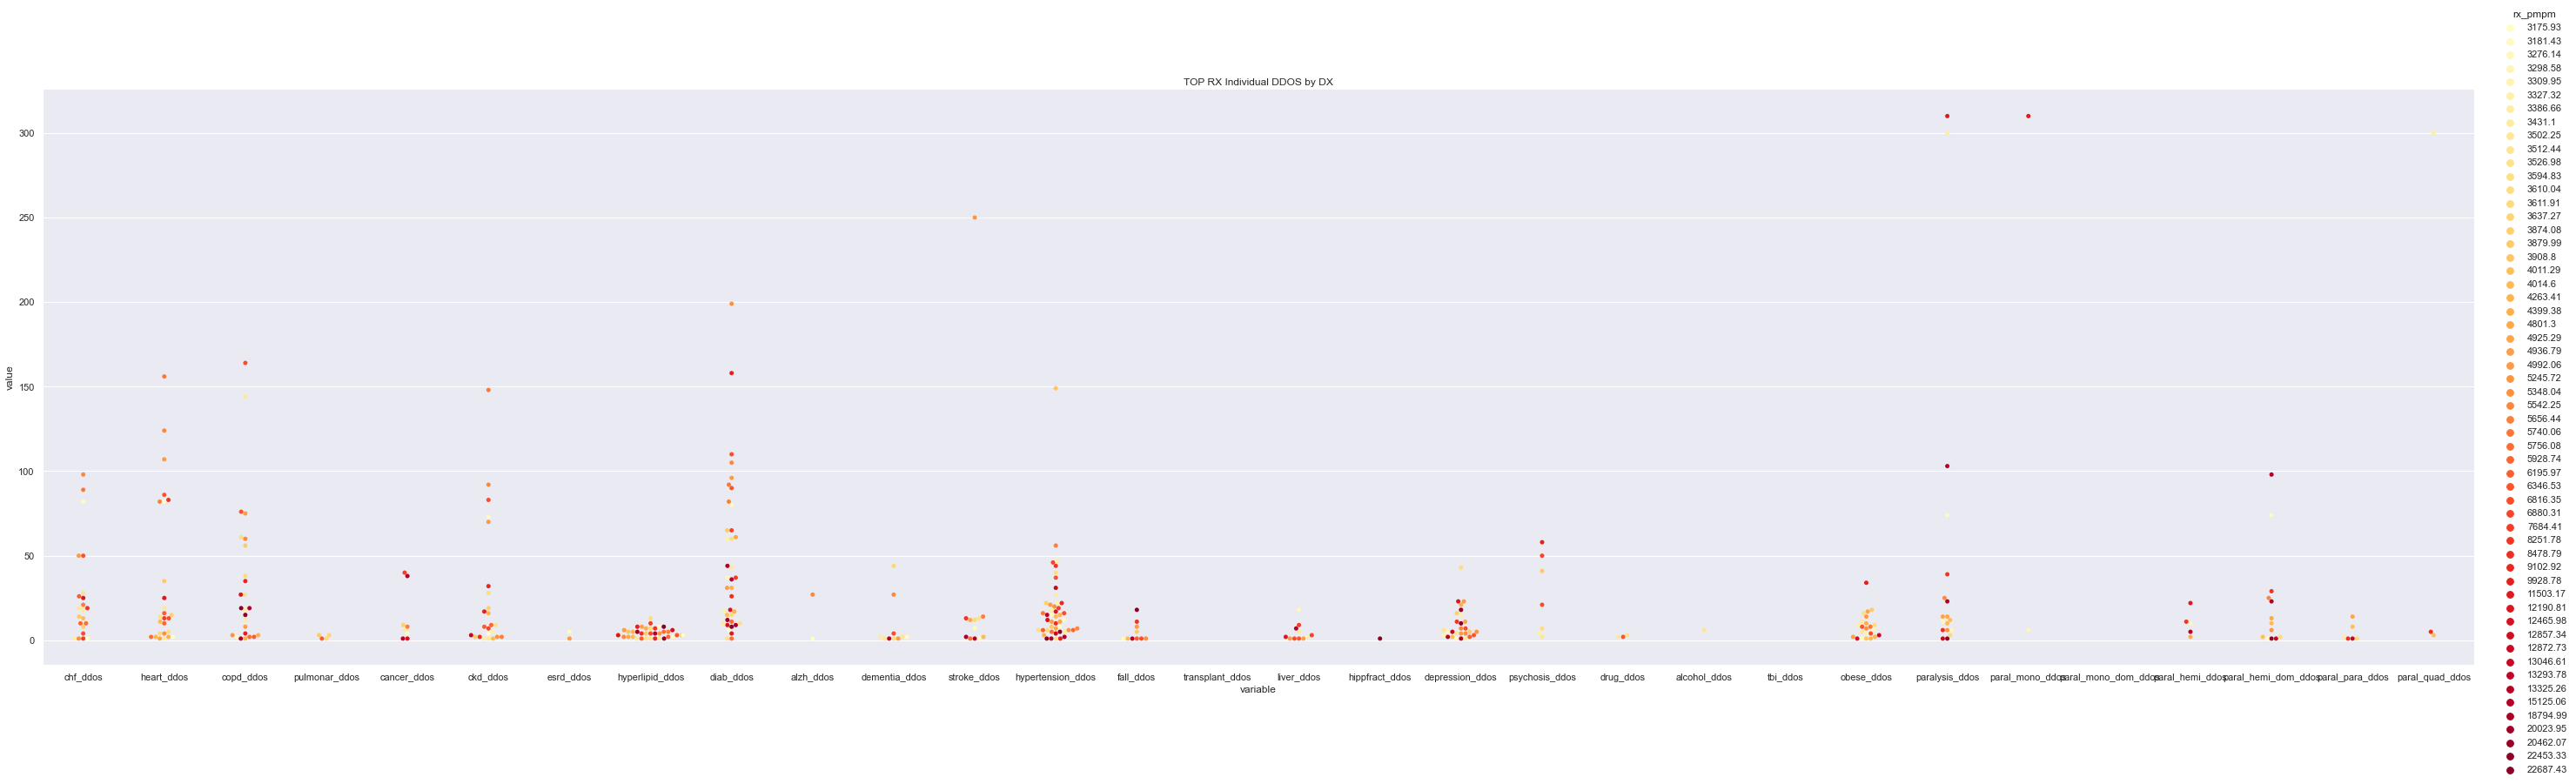

In [33]:
rx_melt = rx_risk[dx_ddos + ['pmpm', 'rx_pmpm']].melt(id_vars=['pmpm', 'rx_pmpm'])
g = sns.catplot(x='variable', y='value', hue='rx_pmpm', kind='swarm', palette='YlOrRd', data=rx_melt, height=10, aspect=4)
g.set(title='TOP RX Individual DDOS by DX')

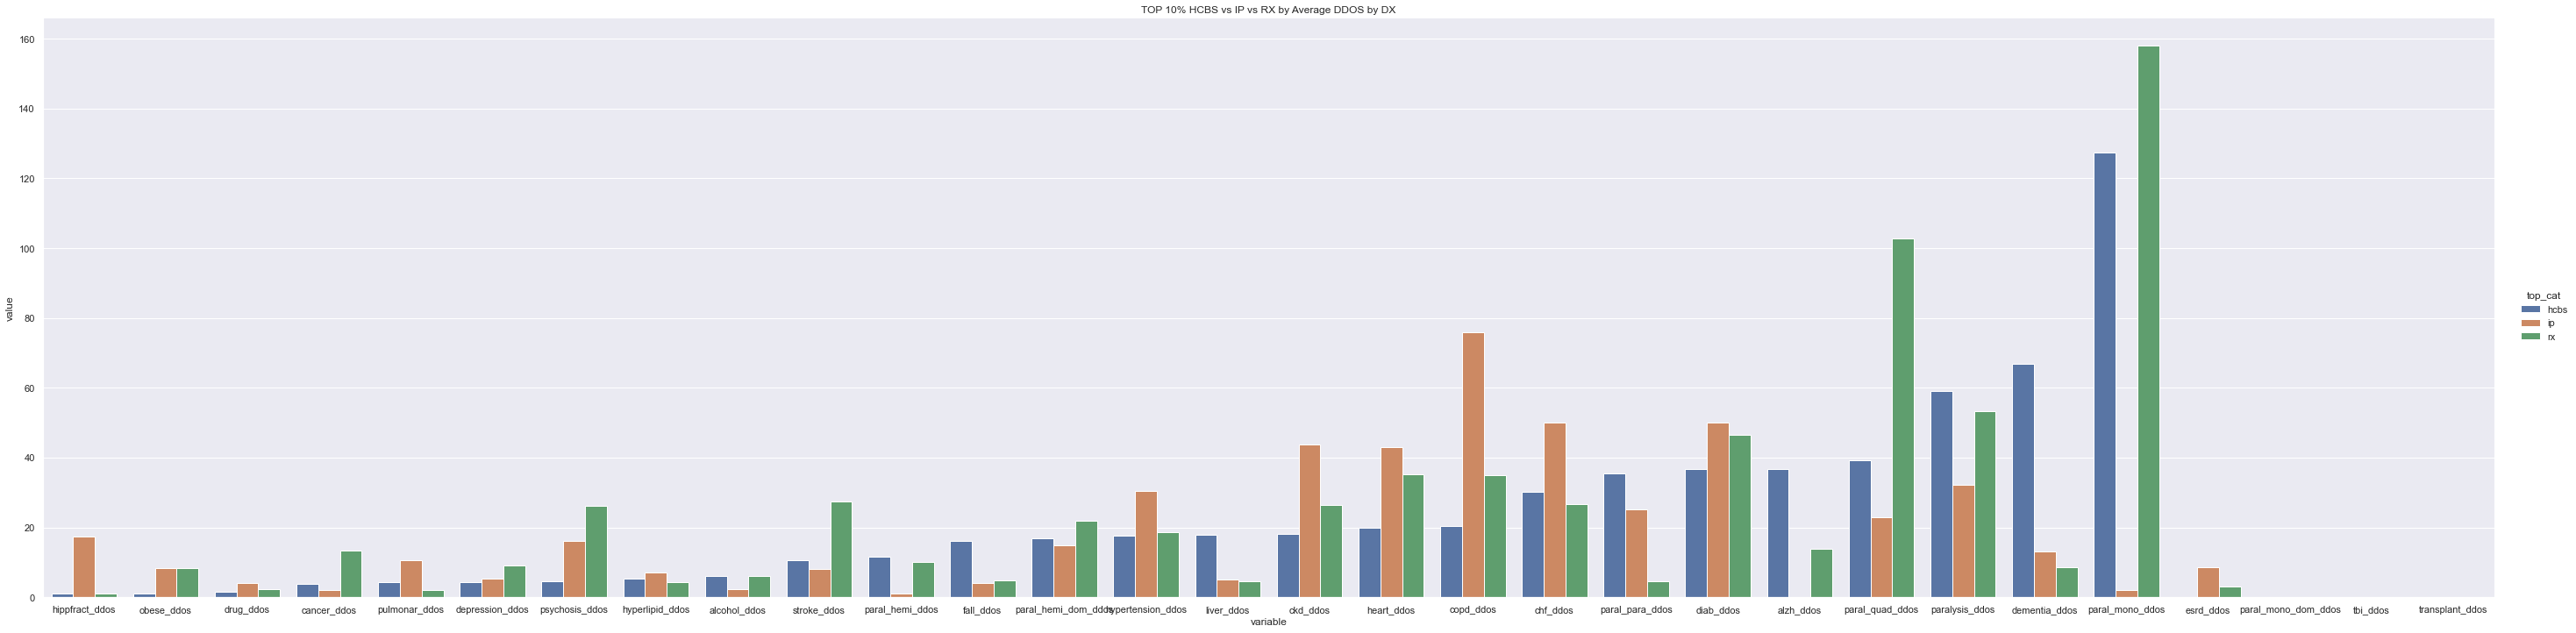

In [47]:
hcbs_dx_melt_grped = hcbs_dx_melt_grped.assign(top_cat='hcbs')
ip_dx_melt_grped = ip_dx_melt_grped.assign(top_cat='ip')
rx_dx_melt_grped = rx_dx_melt_grped.assign(top_cat='rx')
comb = pd.concat([hcbs_dx_melt_grped, ip_dx_melt_grped, rx_dx_melt_grped], sort=True)
g = sns.catplot(x='variable', y='value', hue_order=['hcbs', 'ip', 'rx'], hue='top_cat', kind='bar', data=comb, height=10, aspect=4)
g.set(title="TOP 10% HCBS vs IP vs RX by Average DDOS by DX")